# Exercise 7
 **Note:** because of the Astrophysics' network taking too long to run, we didn't include this network in the computation.

Import the libraries that we'll use

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.linalg import expm
import pandas as pd
import time
from IPython.display import display, HTML, display_pretty
#import warnings
#warnings.simplefilter("ignore")

# A flag to use timer, just to prevent your system to freeze while running heavy processes
useTimer = False #this feature is disabled

Create a class to encapsulate and do the graph operations

In [2]:
class Network:

    def __init__(self, name=None):
        self.name = name

    # Read graph from file and apply transformations
    def read_graph(self, inputFile):
        # To read the network from a file, we use the command read_edgelist.
        G= nx.read_edgelist(inputFile, comments='%', nodetype=int, data=(('weight',float),))
        # We transfor the network into the undirected version.
        G = G.to_undirected()
        # Here we consider only the largest component.
        Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        G=Gcc[0]
        # Sometimes the node labels are not in the sequential order or strings are used. To facilitate our implementation, let us convert the labels to integers starting with the index zero, because Python uses 0-based indexing.
        G = nx.convert_node_labels_to_integers(G, first_label=0)
        # Save graph to the network
        self.graph = G
        return self.graph

    # ### Transitivity
    # Store and return the transitivity of the graph
    def transitivity(self):
        self.transitivity = nx.transitivity(self.graph)
        return self.transitivity

    # ### Average Clustering Cofficient
    # Store and return the average clustering coefficient of the graph
    def average_clustering(self):
        self.average_clustering = nx.average_clustering(self.graph)
        return self.average_clustering

    # Get number of edges of the graph
    def number_of_edges(self):
        self.number_of_edges = self.graph.number_of_edges()
        return self.number_of_edges

    # Get number of nodes of the graph
    def number_of_nodes(self):
        self.number_of_nodes = len(self.graph)
        return self.number_of_nodes


    # Calculate degree distribution
    def degree_distribution(self):
        vk = dict(self.graph.degree())
        vk = list(vk.values())  # we get only the degree values
        vk = np.array(vk)
        maxk = np.max(vk)
        mink = np.min(vk)
        kvalues= np.arange(0,maxk+1) # possible values of k
        Pk = np.zeros(maxk+1) # P(k)
        for k in vk:
            Pk[k] = Pk[k] + 1
        Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
        self.degree_distribution = (kvalues, Pk)
        return self.degree_distribution

    # Plot degree distribution
    def plot_degree_distribution(self):
        fig = plt.subplot(1,1,1)
        fig.set_xscale('log')
        fig.set_yscale('log')
        plt.suptitle(self.name, fontsize=16)
        plt.plot(self.degree_distribution[0],self.degree_distribution[1],'bo')
        plt.xlabel("k", fontsize=20)
        plt.ylabel("P(k)", fontsize=20)
        plt.title('Degree distribution', fontsize=20)
        plt.show(block=True)
        plt.clf()

    # Plot the graph
    def plot_graph(self):
        plt.figure(figsize=(10,10))
        pos=nx.spring_layout(self.graph)
        nx.draw(self.graph, with_labels = True, pos = pos)
        plt.show(block=True)
        plt.clf()

Now we'll calculate Transitivity and Average Clustering Cofficient for each network. Then we store it in a dict to present it at the end.

In [3]:
def main():

    # This line is a strange hack to prevent jupyter from sending a warning called:
    # [IPKernelApp] WARNING | WARNING: attempted to send message from fork
    # On github there is a similar issue still opened: <https://github.com/tqdm/tqdm/issues/485>
    print(' ', end='', flush=True)

    # List of files to open
    networkFiles = [
                    #"../data/out.ca-AstroPh",
                    '../data/out.ego-facebook',
                    '../data/out.petster-friendships-hamster-uniq',
                    '../data/out.subelj_euroroad_euroroad'
    ]

    # List of names of the networks
    networkNames = [
                    #'ArXiv’s Astrophysics',
                    'Facebook user-user friendships',
                    'Hamsterster friendships',
                    'E-road network'
    ]

    # Dict with data to show
    data = {'Network':[], 'Transitivity':[], 'Average Clustering Coefficient':[]}

    # For each network
    for i in range(len(networkFiles)):
        # Load network
        network = Network(name=networkNames[i])
        network.read_graph(networkFiles[i])

        # Let us verify the number of nodes and edges of the network.
        #print('Number of nodes:', network.number_of_nodes())
        #print('Number of edges:', network.number_of_edges())

        # Append network name
        data['Network'].append(networkNames[i])

        # Calculate transitivity
        data['Transitivity'].append(network.transitivity())


        # Calculate Average Clustering Cofficient
        data['Average Clustering Coefficient'].append(network.average_clustering())

        network.degree_distribution()
        network.plot_degree_distribution()


    # Display DataFrame
    df = pd.DataFrame(data)
    display(df)

Here we create a process to run the main function. The advantage of using this strategy, instead of directly invoking main(), is that it gives us more control to stop the program.
 If we set the useTimer variable at the beginning of the program to True, the timer will stop the main process after 60 seconds. It's useful when we hit Ctrl+C in the terminal and the program refuses to stop.
 Also, it's important to catch the KeyboardInterrupt exception, that is raised when we hit Ctrl+C.
 By default, Ctrl+C would kill our program and the process that we've created would still continue to run.
 When we catch the exception, we also terminate the process of the function main. This way, Ctrl+C works again.

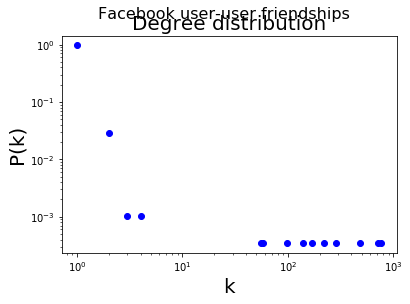

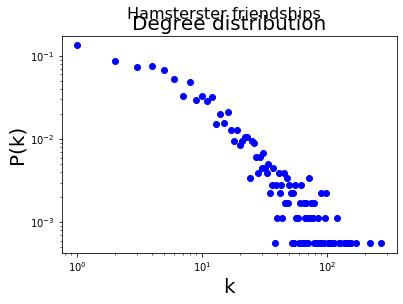

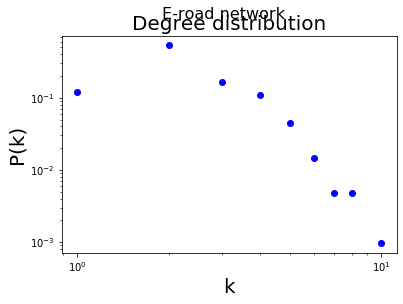

,Network,Transitivity,Average Clustering Coefficient
0,Facebook user-user friendships,0.000359,0.027247
1,Hamsterster friendships,0.090369,0.143305
2,E-road network,0.035255,0.018906


In [4]:
from multiprocessing import Process
from threading import Timer
if __name__ == "__main__":
    # Create the main process
    proc = Process(target=main)

    # Use timer if set
    if(useTimer):
        #declare timer, it gets the time in seconds
        timer = Timer(300, proc.terminate)
        timer.start()

    try:
        # Start process
        proc.start()

        # Block until process terminate
        proc.join()
    except KeyboardInterrupt:
        proc.terminate()

    # If process ends in time, cancel timer
    if(useTimer):
        timer.cancel()

When we run this code, we'll see that the average clustering coefficient and the transitivity diverge in some networks. As stated on Wikipedia:

 *It is worth noting that this metric (average clustering coefficient) places more weight on the low degree nodes, while the transitivity ratio places more weight on the high degree nodes. In fact, a weighted average where each local clustering score is weighted by $k_{i}(k_{i}-1)$ is identical to the global clustering coefficient* - [Wikipedia](https://en.wikipedia.org/wiki/Clustering_coefficient)

 To understand the effect of this in our networks we also plotted the degree distribution of the networks. The Facebook network, for example, has a great amount of nodes with low degree and a small amount of nodes with high degree. The low degree nodes are well clustered (like normal people in their social cycle), so the weight of these low degree nodes makes the average clustering coefficient higher than the transitivity ratio. Also, the nodes with high degree are connected with groups that are not well connected among themselves, so the clustering of high degree nodes is low.

The opposite happens in the E-road network, for example, where the discrepancy among the number of high-degree nodes and the number of low-degree nodes is not as big. In this case, the high degree nodes have more impact on the transitivity ratio than on the average clustering coefficient.